In [179]:
!pip install torch

Defaulting to user installation because normal site-packages is not writeable


In [180]:
import numpy as np
import torch
import torch.nn as nn 
from torch.utils.data import DataLoader
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import scipy.stats
from scipy import signal
from ast import literal_eval
import torch

from sklearn.model_selection import train_test_split

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

pd.set_option('display.max_columns', None)

DATAPATH = "~/datasets/stressrecov"

EXTENSION = "/oura"

sleep_df = pd.read_parquet("~/stressrecovery/data/processed/oura/sleep_concat.parquet")

sleep_df['date']=sleep_df['date'].astype(str) 

daily_merged = pd.read_parquet("~/stressrecovery/data/processed/survey/daily_merged.parquet")
daily_merged['date']=daily_merged['date'].astype(str) 

daily_merged["covid_shift_any"] = daily_merged.apply (lambda row: (row.daily_covid_shifts___1 or row.daily_covid_shifts___2 or row.daily_covid_shifts___3 ), axis=1)

In [181]:
df = pd.merge(sleep_df, daily_merged,  how='left', on=["participant_id","date"])
df['date'] = df["date"].astype(str)
df['date'] = pd.to_datetime(df["date"])

df.sort_values(['participant_id', 'date'], ascending=True)


,awake,bedtime_end,bedtime_end_delta,bedtime_start,bedtime_start_delta,breath_average,deep,duration,efficiency,hr_5min,hr_average,hr_lowest,hypnogram_5min,is_longest,light,midpoint_at_delta,midpoint_time,onset_latency,period_id,rem,restless,rmssd,rmssd_5min,score,score_alignment,score_deep,score_disturbances,score_efficiency,score_latency,score_rem,score_total,summary_date,temperature_delta,temperature_deviation,temperature_trend_deviation,total,participant_id,date,record_id_x,redcap_repeat_instrument_x,redcap_repeat_instance_x,daily_stressed,daily_timing___1,daily_timing___2,daily_timing___3,daily_timing___4,daily_timing___5,daily_duration,daily_control,daily_cause,daily_5a,daily_reduce,daily_6a,daily_shifts,daily_covid_shifts___1,daily_covid_shifts___2,daily_covid_shifts___3,daily_arrive,daily_leave,daily_ts,daily858_uuid,daily858_startdate,daily858_enddate,daily858_scheduledate,daily858_status,daily858_serializedresult,daily_stress_measure_complete,record_id_y,redcap_repeat_instrument_y,redcap_repeat_instance_y,ema_1,ema_2,ema_ts,cou_uuid,cou_startdate,cou_enddate,cou_scheduledate,cou_status,cou_serializedresult,cough_ema_complete,work24,sam1,sam2,sam3,sam4,sam5,sam6,sam7,sam8,sam_ts,sam944_uuid,sam944_startdate,sam944_enddate,sam944_scheduledate,sam944_status,sam944_serializedresult,selfassessment_mannequin_sam_complete,ppe_change,covid_past_24,ppe_2,ppe_3,ppe_4,ppe_5,ppe_6,ppe_ts,ppe_uuid,ppe_startdate,ppe_enddate,ppe_scheduledate,ppe_status,ppe_serializedresult,ppe_and_exposure_scale_complete,covid_shift_any
0,2850,2020-05-28T05:41:30-04:00,20490,2020-05-27T21:27:30-04:00,-9150,15.750,9000,29640,90,"[62, 57, 56, 57, 60, 61, 58, 59, 59, 60, 60, 6...",57.35,50.0,2211111111111313333322211111111122122222222112...,1,13740,5160,14310,120,1,4050,29,129.0,"[95, 144, 145, 115, 104, 106, 108, 96, 93, 96,...",79,100,100,66,96,64,57,79,2020-05-27,-0.17,-0.17,0.32,26790,U-11YJYE852QXSR8AUC2W1,2020-05-27,15.0,daily_stress_measure,5.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,None,NaN,None,0.0,0.0,0.0,0.0,None,None,None,D620D461-B8B3-4FFC-808B-DF979FC9D28C,2020-05-27 20:46:35,2020-05-27 20:46:43,2020-05-27 12:00:00,1.0,result.zip,0.0,15.0,cough_ema,4.0,0.0,NaN,None,C454D525-0003-45A5-A58E-76870D07916B,2020-05-27 20:46:45,2020-05-27 20:46:50,2020-05-27 12:00:00,1.0,result.zip,0.0,NaN,1.0,2.0,2.0,3.0,1.0,2.0,6.0,4.0,None,0EF62BCB-A9F2-4ADA-8E21-AA7265BD97C4,2020-05-27 20:46:51,2020-05-27 20:47:28,2020-05-27 12:00:00,1.0,result.zip,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,None,68925B98-CF8E-4771-A07E-464A32C94C94,2020-05-27 20:47:31,2020-05-27 20:47:37,2020-05-27 12:00:00,1.0,result.zip,0.0,0.0
96,2850,2020-05-28T05:41:30-04:00,20490,2020-05-27T21:27:30-04:00,-9150,15.750,9000,29640,90,"[62, 57, 56, 57, 60, 61, 58, 59, 59, 60, 60, 6...",57.35,50.0,2211111111111313333322211111111122122222222112...,1,13740,5160,14310,120,1,4050,29,129.0,"[95, 144, 145, 115, 104, 106, 108, 96, 93, 96,...",79,100,100,66,96,64,57,79,2020-05-27,-0.17,-0.17,0.32,26790,U-11YJYE852QXSR8AUC2W1,2020-05-27,15.0,daily_stress_measure,5.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,None,NaN,None,0.0,0.0,0.0,0.0,None,None,None,D620D461-B8B3-4FFC-808B-DF979FC9D28C,2020-05-27 20:46:35,2020-05-27 20:46:43,2020-05-27 12:00:00,1.0,result.zip,0.0,15.0,cough_ema,4.0,0.0,NaN,None,C454D525-0003-45A5-A58E-76870D07916B,2020-05-27 20:46:45,2020-05-27 20:46:50,2020-05-27 12:00:00,1.0,result.zip,0.0,NaN,1.0,2.0,2.0,3.0,1.0,2.0,6.0,4.0,None,0EF62BCB-A9F2-4ADA-8E21-AA7265BD97C4,2020-05-27 20:46:51,2020-05-27 20:47:28,2020-05-27 12:00:00,1.0,result.zip,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,None,68925B98-CF8E-4771-A07E-464A32C94C94,2020-05-27 20:47:31,2020-05-27 20:47:37,2020-05-27 12:00:00,1.0,result.zip,0.0,0.0
1,2250,2020-05-29T05:52:22-04:00,21142,2020-05-28T21:24:22-04:00,-9338,16.000,9060,30480,93,"[70, 70, 70, 71, 71, 70, 70, 70, 71, 71, 72, 7...",62.21,55.0,4211111111111244322211222111211122232222222221...,1,14970,5992,15330,300,0,4200,29,103.0,"[49, 46, 39, 38, 43, 41, 40, 45, 36, 38, 32, 3...",84,100,100,76

In [182]:

#df = df.dropna(subset = ["daily_shifts", "daily_covid_shifts___1", "daily_covid_shifts___2", "daily_covid_shifts___3"])
df =df.dropna(subset=["hr_5min","rmssd_5min"])
df["shift_any"] = df.apply (lambda row: (row.daily_shifts ==1.0 or row.daily_shifts==2.0), axis=1)
df["covid_shift_any"] = df["covid_shift_any"].astype(bool)

def covidshift(row):
    if row["covid_shift_any"] and row["shift_any"]:
        return True
    elif row["shift_any"] == False:
        return None
    else:
        return False


def array_preprocess_DROP(arr):
    dropped = arr[arr!=0]
    if len(dropped)!=0:
        return arr[arr!=0]
    else:
        return None

df["covidshift"] = df.apply (lambda row: covidshift(row), axis=1)

#Turn to literal arrays and drop 0s (missing values)
df["hr_5min"] = df.apply (lambda row: array_preprocess_DROP(np.array(literal_eval(row.hr_5min))), axis=1)
df["rmssd_5min"] = df.apply (lambda row: array_preprocess_DROP(np.array(literal_eval(row.rmssd_5min))), axis=1)

#DROPPING NANs AGAIN BECAUSE PREVIOUS OPERATION WOULD HAVE GENERATED NANs ie: array of [0,0,0] -> NaN
df =df.dropna(subset=["hr_5min","rmssd_5min"])

df["rmssd_lowest"] = df.apply (lambda row: np.amin(row.rmssd_5min), axis=1)

df["hr_max"] = df.apply (lambda row: np.amax(row.hr_5min), axis=1)
df["rmssd_max"] = df.apply (lambda row: np.amax(row.rmssd_5min), axis=1)

df["hr_1quantile"] = df.apply (lambda row: np.quantile(row.hr_5min, 0.25), axis=1)
df["rmssd_1quantile"] = df.apply (lambda row: np.quantile(row.rmssd_5min, 0.25), axis=1)

df["hr_2quantile"] = df.apply (lambda row: np.quantile(row.hr_5min, 0.50), axis=1)
df["rmssd_2quantile"] = df.apply (lambda row: np.quantile(row.rmssd_5min, 0.50), axis=1)

df["hr_3quantile"] = df.apply (lambda row: np.quantile(row.hr_5min, 0.75), axis=1)
df["rmssd_3quantile"] = df.apply (lambda row: np.quantile(row.rmssd_5min, 0.75), axis=1)

In [183]:
#Columns of data we want to keep (contains input and output, output is dropped later)

all_columns = ["awake","breath_average", "deep", "duration", "hr_average", "hr_lowest",
          "light", "onset_latency", "rem", "restless", "rmssd", "temperature_delta", "temperature_trend_deviation",
          "total", "daily_stressed", "daily_shifts", "daily_control", "daily_reduce", "rmssd_lowest","hr_max",
           "rmssd_max", "hr_1quantile", "rmssd_1quantile", "hr_2quantile", "rmssd_2quantile", "hr_3quantile",
          "rmssd_3quantile", "score", "score_bin_0", "score_bin_1", "score_bin_2", "score_bin_3", "score_bin_4"]
#Columns to keep (date, participant_id, daily_stressed dropped post processing)
columns = ["date","participant_id", "deep", "rmssd","hr_average","score_bin_0", "score_bin_1", "score_bin_2", "score_bin_3", "score_bin_4"]
df_clean = df.copy()
df = df[['date', 'participant_id','rmssd','hr_average','daily_stressed']]


In [184]:
# Load Participant Train/Val/Test Split dictionary
read_dictionary = np.load('participant_splits.npy',allow_pickle='TRUE').item()

train_df = df[df["participant_id"].isin(read_dictionary["train"])]
val_df = df[df["participant_id"].isin(read_dictionary["val"])]
test_df = df[df["participant_id"].isin(read_dictionary["test"])]

train_df.head()

,date,participant_id,rmssd,hr_average,daily_stressed
0,2020-05-27,U-11YJYE852QXSR8AUC2W1,129.0,57.35,0.0
1,2020-05-28,U-11YJYE852QXSR8AUC2W1,103.0,62.21,1.0
2,2020-05-29,U-11YJYE852QXSR8AUC2W1,88.0,61.81,0.0
3,2020-05-30,U-11YJYE852QXSR8AUC2W1,87.0,65.92,NaN
4,2020-05-31,U-11YJYE852QXSR8AUC2W1,72.0,67.13,0.0


In [185]:
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings(action='ignore')

def construct_dataset(df, duration):
    y = []
    x = []
    
    
    participants = df.participant_id.unique()

    for participant in participants:
        df = df[df["participant_id"] == participant]
        
        #Create Empty NaN rows for missing dates
        df = df.set_index('date')
        df = df.resample('D').mean()
        
        df_imp = df.copy()
        
        #Forward Fill missing values
        df_imp['daily_stressed'] = df_imp['daily_stressed'].fillna(method='ffill')
        
        
        #Loop through windows of window_length. First check to see if there are enough days for at least one window
        #Only get participants who have at least duration days observed (including missing days)
        
        if len(df) >= duration+1:
            
            window = df_imp.iloc[0:duration,:]
            window_y = df.iloc[0:duration,:]
            stress = window_y[["daily_stressed"]]
            
            #create masking matrix
            mask = np.where(np.isnan(df.values),0,1)
            
            #create delta matrix
            S = np.zeros_like(df.values)
            interval=1
            
            for i in range(S.shape[1]):
                S[:,i,:] = interval * i
                
            delta = np.zeros_like(df.values)
            
            for i in range(1, S.shape[1]):
                delta[:,i,:] = S[:,i,:] - S[:,i-1,:]
                
            missing_index = np.where(mask == 0)
            X_last_obsv = np.copy(df.values)
            
            for idx in range(missing_index[0].shape[0]):
                i = missing_index[0][idx] 
                j = missing_index[1][idx]
                k = missing_index[2][idx]
                if j != 0 and j != duration-1:
                    delta[i,j+1,k] = delta[i,j+1,k] + delta[i,j,k]
                if j != 0:
                    #last observation
                    X_last_obsv[i,j,k] = X_last_obsv[i,j-1,k] 
            #normalize
            delta = delta / delta.max() 
        
            #drop label column to prevent leakage
            window = window.drop(["daily_stressed"], axis=1)
            data = window.values
            standardized_data = StandardScaler().fit_transform(data)
            standardized_df = pd.DataFrame(standardized_data)
            arrays = [np.array(standardized_df[column]) for column in standardized_df.columns]
            arrays_y = [np.array(stress[column]) for column in stress.columns]
            x.append(np.stack(arrays, axis=0))
            y.append(np.stack(arrays_y, axis=0))
                    
    return np.array(x), np.array(y)

In [186]:
#groud by participant 
test_df = test_df[test_df.participant_id == 'U-1GPMFTVN6JZLK4G5UKFA']

In [187]:
#create empty rows for missing dates
test_df = test_df.set_index('date')
test_df = test_df.resample('D').mean()

In [188]:
#ffill label
test_df['daily_stressed'] = test_df['daily_stressed'].fillna(method='ffill')

In [189]:
#masking matrix
stress = test_df['daily_stressed']
test_df =  test_df.drop(["daily_stressed"], axis=1)


# forward fill (not the one used for creating the mask array)
test_df_imp = test_df.copy()
test_df_imp = test_df_imp.ffill(axis = 0)

In [190]:
test_df

,rmssd,hr_average
date,,
2020-07-29,87.0,51.39
2020-07-30,87.0,49.65
2020-07-31,NaN,NaN
2020-08-01,76.0,48.01
2020-08-02,74.0,48.30
...,...,...
2020-11-06,66.0,52.81
2020-11-07,NaN,NaN
2020-11-08,78.0,54.24


In [191]:
time_len = test_df.shape[0]
seq_len = 10
pred_len = 1
sequences, labels, sequences_tmp = [], [], []

In [192]:
for i in range(time_len - seq_len - pred_len):
    sequences.append(test_df_imp.iloc[i:i+seq_len].values)
    sequences_tmp.append(test_df.iloc[i:i+seq_len].values)
    labels.append(stress.iloc[i+seq_len:i+seq_len+pred_len].values)

In [193]:
b = np.copy(sequences_tmp)
b = np.where(b >= 0, 1, b)
Mask = np.nan_to_num(b)

In [194]:
interval = 1
S = np.zeros_like(sequences) # time stamps
for i in range(S.shape[1]):
    S[:,i,:] = interval * i

In [195]:
Delta = np.zeros_like(sequences)

In [196]:
for i in range(1, S.shape[1]):
    Delta[:,i,:] = S[:,i,:] - S[:,i-1,:]

In [197]:
missing_index = np.where(Mask == 0)
X_last_obsv = np.copy(sequences)
for idx in range(missing_index[0].shape[0]):
  i = missing_index[0][idx] 
  j = missing_index[1][idx]
  k = missing_index[2][idx]
  if j != 0 and j != seq_len-1:
    Delta[i,j+1,k] = Delta[i,j+1,k] + Delta[i,j,k]
  if j != 0:
    X_last_obsv[i,j,k] = X_last_obsv[i,j-1,k] # last observation


In [198]:
Delta = Delta / Delta.max() # normalize

In [199]:
sequences = np.array(sequences)
sample_size = sequences.shape[0]
index = np.arange(sample_size, dtype = int)

In [200]:
sequences = sequences[index]
labels = np.array(labels)[index]

In [201]:
X_last_obsv = X_last_obsv[index]
Mask = Mask[index]
Delta = Delta[index]
sequences = np.expand_dims(sequences, axis=1)
X_last_obsv = np.expand_dims(X_last_obsv, axis=1)
Mask = np.expand_dims(Mask, axis=1)
Delta = np.expand_dims(Delta, axis=1)

In [202]:
dataset_agger = np.concatenate((sequences, X_last_obsv, Mask, Delta), axis = 1)

In [203]:
train_propotion = 0.8
valid_propotion = 0.2
train_index = int(np.floor(sample_size * train_propotion))
valid_index = int(np.floor(sample_size * ( train_propotion + valid_propotion)))

In [204]:
train_data, train_label = dataset_agger[:train_index], labels[:train_index]
valid_data, valid_label = dataset_agger[train_index:valid_index], labels[train_index:valid_index]
test_data, test_label = dataset_agger[valid_index:], labels[valid_index:]

In [205]:
train_data, train_label = torch.Tensor(train_data), torch.Tensor(train_label)
valid_data, valid_label = torch.Tensor(valid_data), torch.Tensor(valid_label)
test_data, test_label = torch.Tensor(test_data), torch.Tensor(test_label)

In [206]:
train_dataset = utils.TensorDataset(train_data, train_label)
valid_dataset = utils.TensorDataset(valid_data, valid_label)
test_dataset = utils.TensorDataset(test_data, test_label)

In [207]:
train_dataloader = utils.DataLoader(train_dataset, shuffle=False, drop_last = True)
valid_dataloader = utils.DataLoader(valid_dataset, shuffle=False, drop_last = True)
test_dataloader = utils.DataLoader(test_dataset, shuffle=False, drop_last = True)

In [208]:
X_mean = np.mean(sequences, axis = 0)

In [209]:
inputs, labels = next(iter(train_dataloader))

In [210]:
print(inputs.shape, labels.shape)
[batch_size, type_size, step_size, fea_size] = inputs.size()

torch.Size([1, 4, 10, 2]) torch.Size([1, 1])


In [211]:
input_dim = fea_size
hidden_dim = fea_size
output_dim = fea_size

In [216]:
grud = GRUD(input_dim, hidden_dim, output_dim, X_mean, output_last = True)

Model Structure:  GRUD(
  (zl): Linear(in_features=6, out_features=2, bias=True)
  (rl): Linear(in_features=6, out_features=2, bias=True)
  (hl): Linear(in_features=6, out_features=2, bias=True)
  (gamma_x_l): FilterLinear(in_features=2, out_features=2, bias=True)
  (gamma_h_l): Linear(in_features=2, out_features=2, bias=True)
)
Start Training ... 
Output type dermined by the model
Epoch: 0, train_loss: 0.11738466, valid_loss: 0.07611905, time: [1.67], best model: 1
Epoch: 1, train_loss: 0.08493228, valid_loss: 0.02289034, time: [1.66], best model: 1
Epoch: 2, train_loss: 0.07624283, valid_loss: 0.01286263, time: [1.67], best model: 1
Epoch: 3, train_loss: 0.07194691, valid_loss: 0.00833336, time: [1.67], best model: 1
Epoch: 4, train_loss: 0.06952046, valid_loss: 0.00582668, time: [1.65], best model: 1
Epoch: 5, train_loss: 0.06805452, valid_loss: 0.00428514, time: [1.66], best model: 1
Epoch: 6, train_loss: 0.06713421, valid_loss: 0.00327402, time: [1.66], best model: 1
Epoch: 7, tra

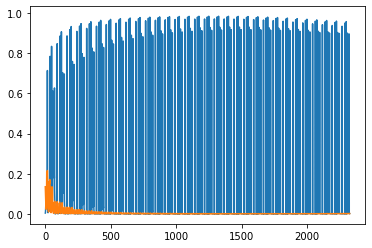

In [217]:
best_grud, losses_grud = Train_Model(grud, train_dataloader, valid_dataloader)